### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

### Carregamento do dados

In [2]:
dataOriginal = pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 
df = dataOriginal 
#pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 

### Tratamento dos dados

In [3]:
# Assim, quando se mexe no dataset original, e se quer voltar atrás, temos o dataOriginal :)
if df['Profit'].isnull().sum() > 0:
    df = df[df['Profit'].notna()]

In [4]:
# Já está justificado no ficheiro data_exploration o porquê de removermos Códigos postais.
#if 'Postal Code' in df.columns:
 #   df = df.drop('Postal Code', axis=1)

df = df.drop(columns = ['Product ID','Customer ID','Postal Code', 'Customer Name', 'Product Name'])

df = df.rename(columns = {'Shipping Cost':'Shipping_Cost'})
df = df.rename(columns = {'Order Priority':'Order_Priority'})

#data['Product Name'] = data['Product Name'].mode().iloc[0]
#data.Order_Priority = most_imputer2.fit_transform(data[['Order_Priority']])

print("Total de valores nulos ")
print(df.isnull().sum())


Total de valores nulos 
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Category          0
Sub-Category      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping_Cost     0
Order_Priority    0
dtype: int64


In [5]:
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['City'] = df['City'].astype('category')
df['State'] = df['State'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Market'] = df['Market'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51200 entries, 32298 to 6147
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Order ID        51200 non-null  object  
 1   Order Date      51200 non-null  object  
 2   Ship Date       51200 non-null  object  
 3   Ship Mode       51200 non-null  category
 4   Segment         51200 non-null  category
 5   City            51200 non-null  category
 6   State           51200 non-null  category
 7   Country         51200 non-null  category
 8   Market          51200 non-null  category
 9   Region          51200 non-null  category
 10  Category        51200 non-null  category
 11  Sub-Category    51200 non-null  category
 12  Sales           51200 non-null  float64 
 13  Quantity        51200 non-null  float64 
 14  Discount        51200 non-null  float64 
 15  Profit          51200 non-null  float64 
 16  Shipping_Cost   51200 non-null  float64 
 17  Order_Pri

In [7]:
def show_frequencies_categorys():
    for coluna in df.select_dtypes(exclude=["number","bool_", "float64"]).columns:
        #print(coluna)
        if df[coluna].nunique() > 10 and ("Date" not in coluna) and ("ID" not in coluna):

            
            #df2=dfgroupby([coluna])[coluna].sum().rename("Courses_fee").groupby(level = 0).transform(lambda x: x/x.sum())
            coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
           # print(coluna_percentagens)
           # print("Exp:")
            values = coluna_percentagens.groupby(coluna_percentagens > 1).filter(lambda x: x.mean() > 1)
            if values.size > 0:
                print("\n", coluna, "'s com mais de 1% de valores\n")
                print(values)

# Juntar países e cidades cuja frequência é menor que uma especificada, para dados categóricos
# Esses dados são: "State", "City", "Country", "Market", "Region"
percentage = 1

#dataset = df.iloc[:]

dataset = df

for coluna in ["State", "City", "Country", "Region", "Sub-Category"]:

        #print(coluna)
        series = dataset.value_counts(dataset[coluna])
        mask = (series/series.sum() * 100).lt(percentage)
        #print(mask,"\n\n")
        dataset[coluna] = np.where(dataset[coluna].isin(series[mask].index),'Other',dataset[coluna])

df = dataset

show_frequencies_categorys()


 State 's com mais de 1% de valores

Other                     79.388672
California                 3.865234
England                    2.927734
New York                   2.187500
Ile-de-France              1.916016
Texas                      1.906250
New South Wales            1.525391
North Rhine-Westphalia     1.404297
Queensland                 1.400391
San Salvador               1.201172
Pennsylvania               1.138672
National Capital           1.138672
Name: State, dtype: float64

 Country 's com mais de 1% de valores

Other                 24.707031
United States         19.343750
Australia              5.541016
France                 5.521484
Mexico                 5.164062
Germany                4.033203
China                  3.671875
United Kingdom         3.189453
Brazil                 3.123047
India                  3.037109
Indonesia              2.714844
Turkey                 2.691406
Italy                  2.164062
Nigeria                1.767578
Spain         

In [8]:
data = df
number_bins = 6

if is_numeric_dtype(data['Discount']):
    # Bins in discount
    print("0 ", data['Discount'])
    min_value = data['Discount'].min()
    print("1", min_value)
    max_value = data['Discount'].max()
    print("2", max_value)
    limits_bins = np.linspace(min_value,max_value , num=number_bins)
    print("3", limits_bins)
    labels_names = []
    for i in range(0, len(limits_bins) - 1):
#    print("Olá")   
        v1 = '{:.2f}'.format(limits_bins[i])
        v2 = '{:.2f}'.format(limits_bins[i+1])
        labels_names.append(f'{v1}-{v2}')
    #print("v1: ", limits_bins[i])
    #print("v2: ", limits_bins[i+1])
    #print("----")
#    data4.loc[data4['score'].between(0, 50, 'both'), 'grade'] = 'C'
#print(labels_names)
    data['Discount'] = pd.cut(x = data['Discount'], bins = limits_bins, labels = labels_names, include_lowest = True)
    
df = data
print(df)

0  Row ID
32298    0.0
26341    0.1
25330    0.1
13524    0.1
47221    0.0
        ... 
24175    0.1
29002    0.0
35398    0.8
9596     0.0
6147     0.0
Name: Discount, Length: 51200, dtype: float64
1 0.0
2 0.85
3 [0.   0.17 0.34 0.51 0.68 0.85]
               Order ID  Order Date   Ship Date       Ship Mode      Segment  \
Row ID                                                                         
32298    CA-2012-124891  31-07-2012  31-07-2012        Same Day     Consumer   
26341     IN-2013-77878  05-02-2013  07-02-2013    Second Class    Corporate   
25330     IN-2013-71249  17-10-2013  18-10-2013     First Class     Consumer   
13524   ES-2013-1579342  28-01-2013  30-01-2013     First Class  Home Office   
47221      SG-2013-4320  05-11-2013  06-11-2013        Same Day     Consumer   
...                 ...         ...         ...             ...          ...   
24175     IN-2014-57662  05-08-2014  10-08-2014  Standard Class  Home Office   
29002     IN-2014-62366  19-06-201

In [9]:
# Tratar das datas
data2 = df

if "Order Date" in data2:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False
    
# Converter datas, acho que já está feito em cima, depois confirmar
dates_order = DatetimeIndex(pd.to_datetime(data2['Order Date'],format='%d-%m-%Y', errors='coerce'))
dates_ship = DatetimeIndex(pd.to_datetime(data2['Ship Date'],format='%d-%m-%Y', errors='coerce'))
if consider_year : 
    data2['Year_order'] = dates_order.year
    data2['Year_ship'] = dates_ship.year
    
if consider_month : 
    data2['Month_order'] = dates_order.month
    data2['Month_ship'] = dates_ship.month

if consider_day : 
    data2['Day_order'] = dates_order.day
    data2['Day_ship'] = dates_ship.day
if 'Order Date' in data2:
    data2 = data2.drop(['Order Date', 'Ship Date'], axis=1)

df = data2

In [10]:
# Juntar datasets de países com PIB por anos


df_pib = pd.read_csv('pibs.csv')


# Nós criamos um dicionário que associa o país ao index para depois a procura ser mais rápida
# A key é o país, o value é o index no dataframe
countries_index = {}
for index, row in df_pib.iterrows():
#    countries_index[row['Country Name']] = index
    countries_index[row['Country Name']] = index
    


In [11]:
df_copy = df

available_years = [2011, 2012, 2013, 2014]

# Para o caso de mais países terem nomes diferentes nos 2 datasets
def convert_countries_name(value):
    if (value=='Iran'):
        return "Iran, Islamic Rep."
    else:
        return value

'''
Atribuímos o valor do primeiro quartil para um país que tenha menos de 1%. 
Esse valor é usado para países que foram marcados como "Other".
'''
def add_pib_value():
    gdp_by_years = {}
    for year in available_years:
        print(year)
        print(df_pib[str(year)].quantile([0.25])[0.25])
        gdp_by_years[year] = df_pib[str(year)].quantile([0.25])[0.25]
    
    return gdp_by_years

# Dicionário que associa anos ao primeiro quartil do PIB desse ano
gdp_to_Other_countries_dic = add_pib_value()



def add_pib_value(value):

    country = convert_countries_name(value['Country'])
    year = value['Year_order']
    if (country == 'Other'):
        return gdp_to_Other_countries_dic[year]
    index_in_df = countries_index[country]
    
    gdp_in_year = df_pib.iloc[index_in_df]
    #Corresponder o ano ao index no df de pib
    year_index = year-2011+1;

    return gdp_in_year[year_index]

df_copy['pib_country'] = df_copy.apply (lambda row: add_pib_value(row), axis=1)
df = df_copy


2011
8106590716.75
2012
8709165249.0
2013
8747773729.5
2014
9297230738.0


In [12]:
# Label encoding de algumas variáveis

if "Category" in data2:
    process_Category = True
    process_Sub_Category = True
    process_Discount = True
else: 
    process_Category = False
    process_Sub_Category = False
    process_Discount = False

lb_make = LabelEncoder()

if process_Category:
    data2["Category LabelEnc"] = lb_make.fit_transform(data2["Category"])

if process_Sub_Category:
    data2["Sub-Category LabelEnc"] = lb_make.fit_transform(data2["Sub-Category"])
    
if process_Discount:
    data2["Discount LabelEnc"] = lb_make.fit_transform(data2["Discount"])

data2 = data2.drop(["Category", "Sub-Category", "Discount"], axis=1)

if data2['Ship Mode'].dtype == 'category' or data2['Ship Mode'].dtype == 'object':
   # print("Ship mode ainda está em categorias")
    #print(data2['Ship Mode'].unique())
    ship_mode_dic = {'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4}
    #dataTemp = pd.DataFrame({"Ship Mode": ship_mode_dic.keys()})
    #print("Aqui vai\n")
    data2["Ship Mode"]= data2["Ship Mode"].apply(lambda x: ship_mode_dic.get(x))
    #print(data2)

if "Order_Priority" in data2 and (data2['Order_Priority'].dtype == 'category' or data2['Order_Priority'].dtype == 'object'):
    dataTemp = data2
    # print("Ship mode ainda está em categorias")
    #print(dataTemp['Order_Priority'].unique())
    priorities_dic = {'Critical':1, 'High':2, 'Medium':3,'Low':4}
    #dataTemp = pd.DataFrame({"Order_Priority": priorities_dic.keys()})
    #print("Aqui vai\n")
    dataTemp["Order_Priority"]= dataTemp["Order_Priority"].apply(lambda x: priorities_dic.get(x))
    #print(dataTemp.info())
    data2 = dataTemp
    
print("\nApós fazer Label Encoding")
print(data2)

df = data2


Após fazer Label Encoding
               Order ID Ship Mode      Segment           City  \
Row ID                                                          
32298    CA-2012-124891         1     Consumer  New York City   
26341     IN-2013-77878         3    Corporate          Other   
25330     IN-2013-71249         2     Consumer          Other   
13524   ES-2013-1579342         2  Home Office          Other   
47221      SG-2013-4320         1     Consumer          Other   
...                 ...       ...          ...            ...   
24175     IN-2014-57662         4  Home Office          Other   
29002     IN-2014-62366         1    Corporate          Other   
35398    US-2014-102288         4     Consumer          Other   
9596     MX-2012-140767         4  Home Office          Other   
6147     MX-2012-134460         3     Consumer          Other   

                  State        Country  Market      Region     Sales  \
Row ID                                                 

<AxesSubplot:>

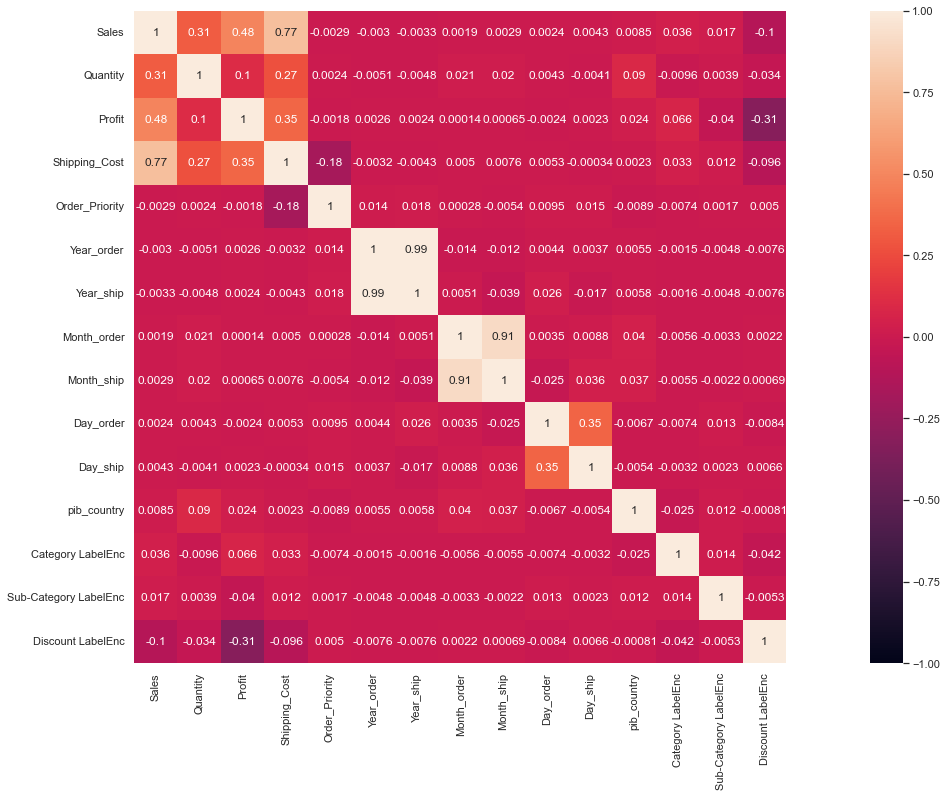

In [13]:
corr_matrix = df.corr()
sns.set(rc={'figure.figsize':(30,12)})
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True,annot=True)

<AxesSubplot:ylabel='Row ID'>

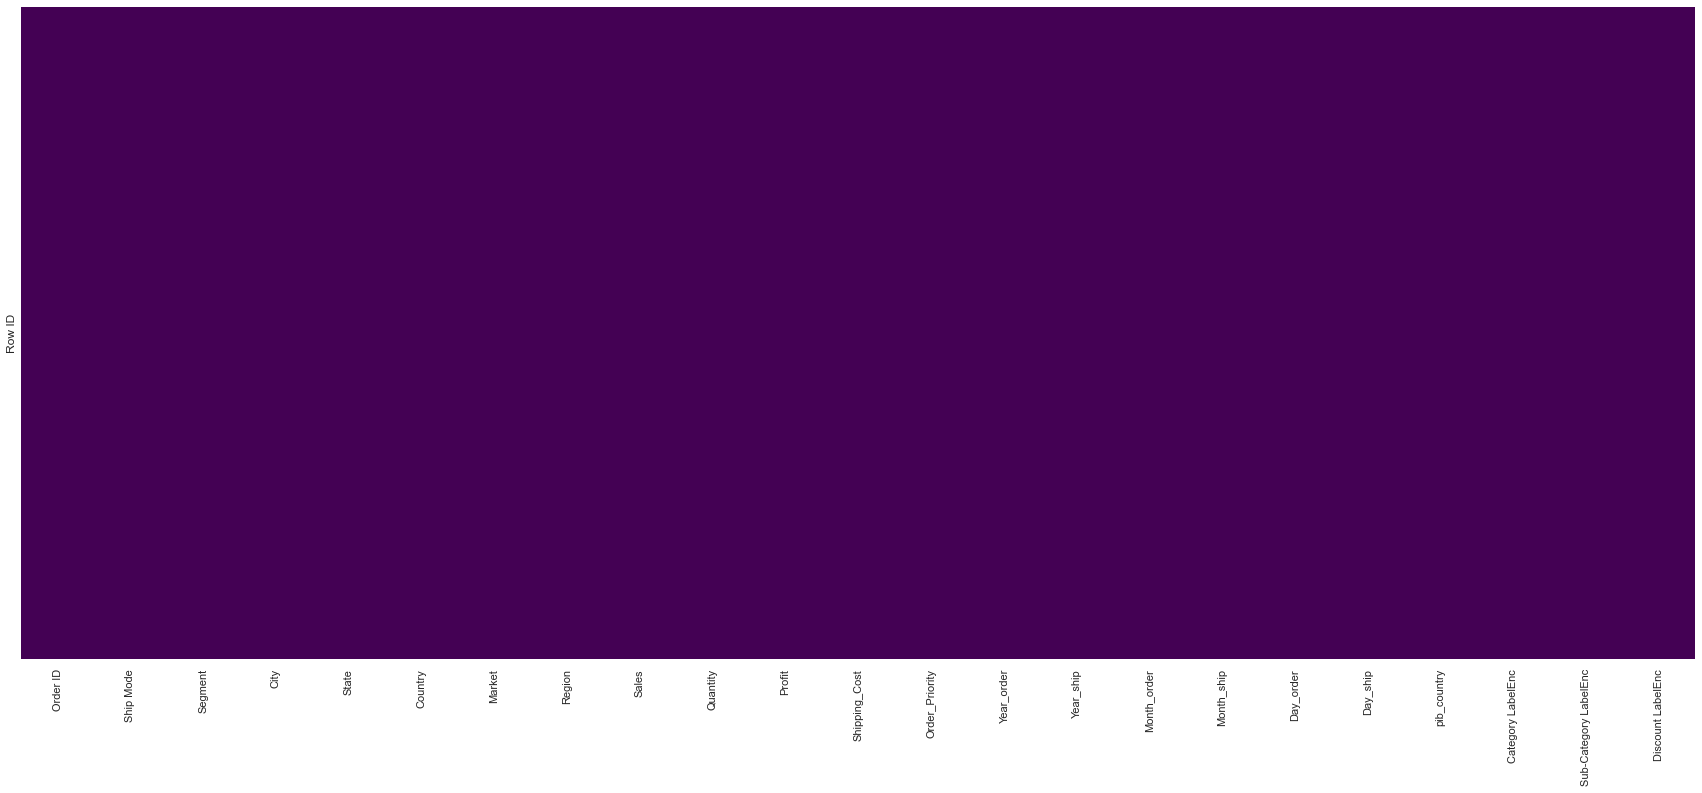

In [14]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [15]:
data4 = df 
#number_bins = 2

if (data4['Ship Mode'].dtypes == 'category'):

    # 'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4
    data4.loc[data4['Ship Mode'] == 4 ,'Ship_mode_binned'] = 0
    data4.loc[data4['Ship Mode'] != 4 ,'Ship_mode_binned'] = 1
    
df = data4
print(df)  

               Order ID Ship Mode      Segment           City  \
Row ID                                                          
32298    CA-2012-124891         1     Consumer  New York City   
26341     IN-2013-77878         3    Corporate          Other   
25330     IN-2013-71249         2     Consumer          Other   
13524   ES-2013-1579342         2  Home Office          Other   
47221      SG-2013-4320         1     Consumer          Other   
...                 ...       ...          ...            ...   
24175     IN-2014-57662         4  Home Office          Other   
29002     IN-2014-62366         1    Corporate          Other   
35398    US-2014-102288         4     Consumer          Other   
9596     MX-2012-140767         4  Home Office          Other   
6147     MX-2012-134460         3     Consumer          Other   

                  State        Country  Market      Region     Sales  \
Row ID                                                                 
32298     

In [16]:
data5 = df 
#number_bins = 2

if (data5['Market'].dtypes == 'category'):

    data5.loc[data4['Market'] == 'Canada' ,'Market_binned'] = 'Canada and US'
    data5.loc[data4['Market'] == 'US' ,'Market_binned'] = 'Canada and US'
    data5.loc[data4['Market'] == 'APAC' ,'Market_binned'] = 'APAC'
    data5.loc[data4['Market'] == 'EU' ,'Market_binned'] = 'EU'
    data5.loc[data4['Market'] == 'Africa' ,'Market_binned'] = 'Africa'
    data5.loc[data4['Market'] == 'EMEA' ,'Market_binned'] = 'EMEA'
    data5.loc[data4['Market'] == 'LATAM' ,'Market_binned'] = 'LATAM'
    
df = data5
print(df)  

               Order ID Ship Mode      Segment           City  \
Row ID                                                          
32298    CA-2012-124891         1     Consumer  New York City   
26341     IN-2013-77878         3    Corporate          Other   
25330     IN-2013-71249         2     Consumer          Other   
13524   ES-2013-1579342         2  Home Office          Other   
47221      SG-2013-4320         1     Consumer          Other   
...                 ...       ...          ...            ...   
24175     IN-2014-57662         4  Home Office          Other   
29002     IN-2014-62366         1    Corporate          Other   
35398    US-2014-102288         4     Consumer          Other   
9596     MX-2012-140767         4  Home Office          Other   
6147     MX-2012-134460         3     Consumer          Other   

                  State        Country  Market      Region     Sales  \
Row ID                                                                 
32298     

In [17]:
ids_cols = ['Customer Name', 'Product ID LabelEnc', 'Costumer ID LabelEnc', 'Product Name', 'Order ID', 'Market' ]


for item in ids_cols: 
    if item in df.columns:
        df = df.drop(item, axis=1)

df.head(1)


,Ship Mode,Segment,City,State,Country,Region,Sales,Quantity,Profit,Shipping_Cost,...,Month_order,Month_ship,Day_order,Day_ship,pib_country,Category LabelEnc,Sub-Category LabelEnc,Discount LabelEnc,Ship_mode_binned,Market_binned
Row ID,,,,,,,,,,,,,,,,,,,,,
32298,1,Consumer,New York City,New York,United States,East,2309.65,7.0,762.1845,933.57,...,7,7,31,31,1.619700e+13,2,0,0,1.0,Canada and US


In [18]:
from sklearn.preprocessing import LabelEncoder

# Label encoding de algumas variáveis
lb_make = LabelEncoder()
categorical_columns = df.select_dtypes(exclude=["number","bool_"]).columns

for item in categorical_columns:
    df[item] = lb_make.fit_transform(df[item])



In [19]:
df.to_csv("new_Global_Superstore_With_Outliers.csv")

In [21]:
array = []

for num in ["Sales", "Profit", "Shipping_Cost"]:
    Q1 = df[num].quantile(0.25)
    Q3 = df[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    array.append((num,lower,upper))

print(array)

### Tratar os outliers das features numéricas:
### Substituir os valores dos outliers pela mediana
i = 0
for num in ["Sales", "Profit", "Shipping_Cost"]:
    median = np.median(df[num])
    df.loc[df[num] <= array[i][1], num] = median
    df.loc[df[num] >= array[i][2], num] = median
    i = i + 1


[('Sales', -300.26, 582.78), ('Profit', -55.26225000000001, 92.10375000000002), ('Shipping_Cost', -30.245, 57.395)]


In [27]:
df.to_csv("new_Global_Superstore_treated_Outliers.csv")

In [24]:
# Remove outliers
for coluna in df[["Profit", "Shipping_Cost", "Sales"]]:
    df = df[
        (df[coluna] < df[coluna].mean() + 3 * df[coluna].std()) & 
        (df[coluna] > df[coluna].mean() - 3 * df[coluna].std())
    ]

df.shape

(47892, 23)

In [25]:
df.to_csv("new_Global_Superstore_Without_Outliers.csv")

In [26]:
#código que na feature order priority, junta o low com o medium e o critical com o high (não colocar no ficheiro das redes neuronais)
data6 = df 

if (data6['Order_Priority'].dtypes == 'int64'):

    #Critical:1, High:2, Medium:3, Low:4
    data6.loc[data6['Order_Priority'] == 3 ,'Order_priority_binned'] = 0
    data6.loc[data6['Order_Priority'] == 4 ,'Order_priority_binned'] = 0
    data6.loc[data6['Order_Priority'] == 2 ,'Order_priority_binned'] = 1
    data6.loc[data6['Order_Priority'] == 1 ,'Order_priority_binned'] = 1
    
df = data6
print(df)  

        Ship Mode  Segment  City  State  Country  Region    Sales  Quantity  \
Row ID                                                                        
32298           0        0     1      5       23       5  85.2738       7.0   
26341           2        1     2      4        0       8  85.2738       9.0   
25330           1        0     2      9        0       8  85.2738       9.0   
13524           1        2     2      7        7       2  85.2738       5.0   
47221           0        0     2      7       18       0  85.2738       8.0   
...           ...      ...   ...    ...      ...     ...      ...       ...   
24175           3        2     2      9        0       8  58.0500       5.0   
29002           0        1     2      7       18       7  65.1000       5.0   
35398           3        0     2     11       23       2   0.4440       1.0   
9596            3        2     2      7        1      10  13.4400       2.0   
6147            2        0     2      7       16    